In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt
import h5py

from datasets.generators1d import * 
from models.utils import pbar, tensor_diff, tensor_roll

In [2]:
OMEGA = 1.215e15
MU0 = 4 * np.pi * 10**-7
EPSILON0 =  8.854187817620e-12 
SCALE = 1e-15
C = 299792458.0
L0 = 1e-6
PIXEL_SIZE = 0.05 * L0
wavelength = 2 * np.pi * C / OMEGA

## Cavity experiments

In [79]:
# perms = np.ones(65)
perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

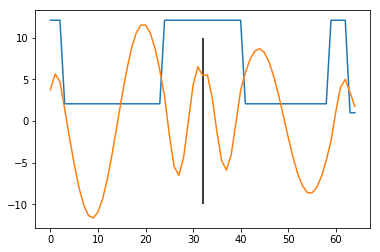

In [80]:
plt.plot(epsilons[16:-16])
plt.plot(np.imag(Ez)[16:-16], label="$E_\mathrm{true}$")
plt.vlines(src_x, -10, 10)
plt.show()


In [83]:
a = torch.tensor(np.imag(Ez)[16:-16])
roll=tensor_roll(a, 1)
dif = tensor_diff(a, n=2, cyclic=True)

zero = torch.tensor([0.0]).double()
# dif2 = torch.cat([zero,tensor_diff(a, n=2, padding=None), zero],dim=-1)
dif2=tensor_diff(a, n=2, padding=True)

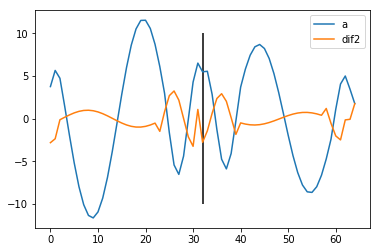

In [84]:
plt.plot(a.numpy(), label='a')
# plt.plot(roll.numpy(), label='roll')
# plt.plot(dif.numpy(), label='dif')
plt.plot(dif2.numpy(), label='dif2')
plt.vlines(src_x, -10, 10)
plt.legend()
plt.show()

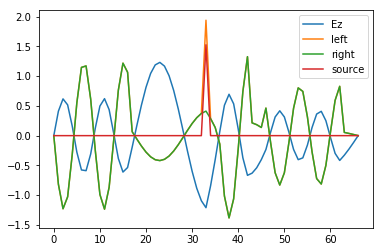

In [94]:
# sourcevals = []
# for i in pbar(range(1000)):

perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

a = torch.cat([zero, torch.tensor(np.imag(Ez)[16:-16]), zero], dim=-1)
diffs = torch.cat([zero, tensor_diff(a, n=2, padding=None), zero], dim=-1)
# diffs = tensor_diff(a, n=2, cyclic=True)

ez = np.concatenate([[0], np.imag(Ez[16:-16]), [0]])

eps = epsilons[16:-16]
barrier = torch.tensor([-1e10]).double()
eps = torch.cat([barrier, torch.tensor(eps), barrier], dim=-1)

# print(a.shape, dif2.shape, ez.shape, eps.shape)

x = PIXEL_SIZE * (np.arange(eps.shape[0]) - src_x)
# Check wave equation terms match
left = SCALE * diffs.numpy() / PIXEL_SIZE**2
right = SCALE * -OMEGA**2 * MU0 * EPSILON0 * eps.numpy() * ez
source = left-right

plt.plot(0.1 * ez, label="Ez")
plt.plot(left, label="left")
plt.plot(right, label="right")

plt.plot(source, label="source")
plt.legend()
plt.show()

# sourcemax = np.max(source[1:-1])
# sourcevals.append(sourcemax)
    

In [3]:
class Perm1dDataset_test(Dataset):
    
    def __init__(self, hdf5_file, batch_name, kernel_sizes = []):
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"] 
        self.src = data["src"]
        self.Ez = data["Ez"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        epsilons = torch.tensor(self.epsilons[i])
        src_x = self.src[i]
        fields = torch.tensor(np.imag(self.Ez[i])) # TODO: change to real
        return epsilons.float(), fields.float()

class Perm1dDataset(Dataset):
    
    def __init__(self, epsilon_generator, kernel_sizes = [], N=10000, size=65, infinite_mode=False):
        self.size = size
        self.epsilon_generator = epsilon_generator
        self.epsilon_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        if self.infinite_mode:
            return int(1e8)
        else:
            return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.epsilon_samples) or self.infinite_mode:
            epsilons = torch.tensor(self.epsilon_generator())
            if not self.infinite_mode:
                self.epsilon_samples.append(epsilons)
            return epsilons, torch.empty_like(epsilons)
        else:
            epsilons = self.epsilon_samples[i]
            return epsilons, torch.empty_like(epsilons)

In [95]:
class MaxwellDense(nn.Module):
    
    def __init__(self, size=65, src_x=32, supervised=False):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.supervised = supervised

        self.layer_dims = [self.size, 128, 256, 256, 128, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < len(self.layers_amp) - 1:
                A = nn.ReLU()(A)
                
        phi = x
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < len(self.layers_amp) - 1:
                phi = nn.ReLU()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons):
        # Get amplitude and phase vectors
        A, phi = self.forward_amplitude_phase(epsilons)
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float) - self.src_x))
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        fields = self.get_fields(epsilons)
        
        if self.supervised:
            labels = torch.empty_like(fields)
            for i, perm in enumerate(epsilons.detach().numpy()):
                _, _, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perm, omega=OMEGA_1550)
                labels[i, :] = torch.tensor(np.imag(Ez[16:-16])).float()
            return fields - labels
        
        else:
            batch_size, _ = epsilons.shape

            # Add zero field amplitudes at edge points for resonator BC's
            zero = torch.zeros((batch_size, 1))
            E = torch.cat([zero, fields, zero], dim=-1)

            # Add first layer of cavity BC's
            barrier = torch.full((batch_size, 1), -1e10)
            eps = torch.cat([barrier, epsilons, barrier], dim=-1)
            
            # Compute Maxwell operator on fields
            diffs = tensor_diff(E, n=2, padding=None)
            curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
            epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

            # Compute free-current vector
            J = torch.zeros_like(E)
            J[:,self.src_x + 1] = 1.526814027933079

            out = curl_curl_E - epsilon_E - J
            return out

In [96]:
def perm_generator_vacuum():
    return np.ones(65)

In [97]:
# Device configuration
device = torch.device('cpu')

# Create a model   
model = MaxwellDense(supervised=False).to(device)
# writer = SummaryWriter()

# Create data loaders
batch_size = 500

# train_data = Perm1dDataset(perm_generator_vacuum, N=1000, infinite_mode=False)
train_data = Perm1dDataset(lambda: perm_alternating_layers(s=65), N=1e5, infinite_mode=False)
test_data = Perm1dDataset_test("datasets/test_1d_unsupervised.hdf5", "alternating_layers")
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [7]:
# Hyperparameters
num_epochs = 1000
learning_rate = 0.00001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.1)
# losses = []

# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = False
    if SHOW_ITERATION_PROGRESS:
        train_loader = pbar(train_loader)
        
    for epsilons, _ in train_loader:
        
        epsilons = epsilons.float().to(device)
        
        # Forward pass
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_loader.set_description("ℒ = {:.2e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.2e}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), 'model1d.ckpt')

In [98]:
model.load_state_dict(torch.load("model1d_nov28.ckpt"))

0.011423110961914062 0.0013949871063232422 0.12211971948572382


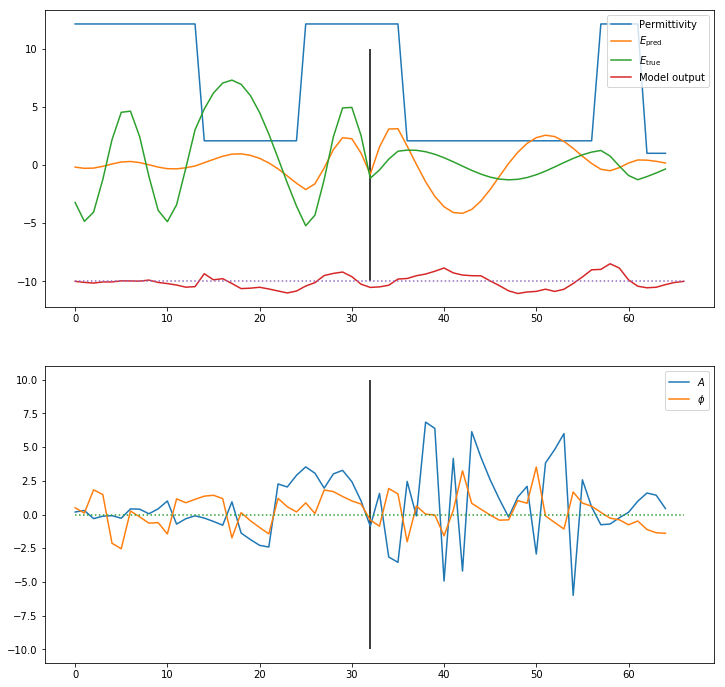

In [135]:
model.eval()

# perms = perm_generator_vacuum()
perms = perm_alternating_layers(s=65)
# perms = perm_random_number_alternating_layers(s=65)
# epsilons = train_loader.dataset[0][0]

start = time()
_, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)
sim_time = time() - start

epsilons = torch.tensor([perms]).float()
start = time()
fields = model.get_fields(epsilons)
network_time = time() - start

A, phi = model.forward_amplitude_phase(epsilons)
outputs = model(epsilons)[0].detach().numpy()

print(sim_time, network_time, network_time / sim_time)

f, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].plot(epsilons[0].detach().numpy(), label="Permittivity")
ax[0].plot(fields[0].detach().numpy(), label="$E_\mathrm{pred}$")
ax[0].plot(np.imag(Ez)[16:-16], label="$E_\mathrm{true}$")
ax[0].plot(-10 + 20*outputs, label="Model output")
ax[0].plot(-10 * np.ones(outputs.shape), linestyle=':')
ax[0].vlines(src_x, -10, 10)
ax[0].legend()

ax[1].plot(A[0].detach().numpy(), label="$A$")
ax[1].plot(phi[0].detach().numpy(), label="$\phi$")
ax[1].plot(np.zeros(outputs.shape), linestyle=':')
ax[1].vlines(src_x, -10, 10)
ax[1].legend()

plt.show()